In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore') 
from sklearn.model_selection import train_test_split,cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

## Data Preprocessing

In [2]:
df = pd.read_csv('COVID_dataset_train.csv',delimiter=',', error_bad_lines=False, warn_bad_lines=True)
df

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,2020-03-30,2020-03-31,2020-03-31,2020-03-30,70s,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
1,2021-01-22,2021-01-24,2021-01-24,2021-01-23,50s,FEMALE,NO KNOWN EPI LINK,Newmarket,NaN,44.048023,-79.480239,Not Resolved
2,2020-03-24,2020-04-14,2020-04-14,2020-04-13,70s,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Resolved
3,2021-01-18,2021-01-21,2021-01-21,2021-01-18,<20,MALE,CC,Mississauga,NaN,43.647471,-79.708893,Not Resolved
4,2020-12-26,2020-12-28,2020-12-28,2020-12-26,60s,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved
...,...,...,...,...,...,...,...,...,...,...,...,...
14855,2020-04-02,2020-04-03,2020-04-04,2020-04-02,90s,FEMALE,NO KNOWN EPI LINK,Whitby,NaN,43.898605,-78.940341,Fatal
14856,2021-01-25,2021-01-26,2021-01-26,2021-01-25,<20,MALE,CC,Thorold,NaN,43.116537,-79.241220,Not Resolved
14857,2020-12-07,2020-12-08,2020-12-08,2020-12-07,40s,FEMALE,CC,Mississauga,NaN,43.647471,-79.708893,Resolved
14858,2020-11-22,2020-11-24,2020-11-24,2020-11-22,20s,UNSPECIFIED,CC,Newmarket,NaN,44.048023,-79.480239,Resolved


In [3]:
df.nunique()

Accurate_Episode_Date      332
Case_Reported_Date         323
Test_Reported_Date         320
Specimen_Date              324
Age_Group                    9
Client_Gender                4
Case_AcquisitionInfo         6
Reporting_PHU_City          34
Outbreak_Related             1
Reporting_PHU_Latitude      34
Reporting_PHU_Longitude     34
Outcome1                     3
dtype: int64

In [4]:
df['Client_Gender'].value_counts()

FEMALE            7562
MALE              7192
UNSPECIFIED        105
GENDER DIVERSE       1
Name: Client_Gender, dtype: int64

In [5]:
df.isnull().sum()

Accurate_Episode_Date         0
Case_Reported_Date            0
Test_Reported_Date          203
Specimen_Date               122
Age_Group                     5
Client_Gender                 0
Case_AcquisitionInfo          0
Reporting_PHU_City            0
Outbreak_Related           9082
Reporting_PHU_Latitude        0
Reporting_PHU_Longitude       0
Outcome1                      0
dtype: int64

We see there are missing values in the columns "Test_Reported_Date", "Specimen_Date", "Age_Group" and "Outbreak_Related".

We are replacing those missing values in the colum "Outbreak_Related" with "No".

In [6]:
df['Outbreak_Related'].replace(np.nan, 'No',inplace=True)
df[df['Age_Group'].isnull()]

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
5659,2021-01-21,2021-01-21,NaN,NaN,NaN,FEMALE,OB,Sudbury,No,46.466092,-80.998059,Not Resolved
6709,2020-12-21,2020-12-21,NaN,NaN,NaN,UNSPECIFIED,NO KNOWN EPI LINK,Windsor,No,42.308796,-83.033670,Fatal
9721,2020-12-27,2020-12-31,2020-12-31,2020-12-27,NaN,FEMALE,OB,Kenora,Yes,49.769615,-94.488254,Resolved
10658,2021-01-24,2021-01-24,NaN,NaN,NaN,UNSPECIFIED,NO KNOWN EPI LINK,Simcoe,No,42.847825,-80.303815,Not Resolved
12316,2021-01-30,2021-01-30,NaN,NaN,NaN,FEMALE,MISSING INFORMATION,Peterborough,No,44.301632,-78.321347,Not Resolved


Above are rows in the data where column "Age_Group" is missing. We are replacing the missing value with the mode of the same column corresponding to a particular "Client_Gender".

In [7]:
df[['Client_Gender','Age_Group']].value_counts()
df_female = df[df.Client_Gender=='FEMALE']
df_female['Age_Group'].fillna('90s',inplace = True)
df_unsp = df[df.Client_Gender=='UNSPECIFIED']
df_unsp['Age_Group'].fillna('80s',inplace = True)
df_gd = df[df.Client_Gender=='GENDER DIVERSE']
df_male = df[df.Client_Gender=='MALE']
df_final = df_male.append([df_gd,df_unsp,df_female])
df_final.shape

(14860, 12)

In [8]:
#Formatting the values of "Age_Group" as appropriate.

df_final["Age_Group"].replace({"90s": 90, "80s": 80,"70s": 70, "60s": 60,"50s": 50, "40s": 40,"30s": 30, "20s": 20, "<20": 19 }, inplace=True)
df_final

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,2020-03-30,2020-03-31,2020-03-31,2020-03-30,70,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
3,2021-01-18,2021-01-21,2021-01-21,2021-01-18,19,MALE,CC,Mississauga,No,43.647471,-79.708893,Not Resolved
4,2020-12-26,2020-12-28,2020-12-28,2020-12-26,60,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved
6,2021-01-23,2021-01-24,2021-01-24,2021-01-23,20,MALE,MISSING INFORMATION,Ottawa,No,45.345665,-75.763912,Not Resolved
8,2021-01-25,2021-01-29,2021-01-29,2021-01-28,40,MALE,CC,Newmarket,No,44.048023,-79.480239,Not Resolved
...,...,...,...,...,...,...,...,...,...,...,...,...
14849,2020-05-10,2020-05-10,2020-05-10,2020-05-08,70,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Fatal
14852,2021-01-20,2021-01-21,2021-01-21,2021-01-20,50,FEMALE,CC,Mississauga,No,43.647471,-79.708893,Not Resolved
14854,2020-04-05,2020-04-05,2020-04-06,2020-04-05,50,FEMALE,OB,St. Thomas,Yes,42.777804,-81.151156,Resolved
14855,2020-04-02,2020-04-03,2020-04-04,2020-04-02,90,FEMALE,NO KNOWN EPI LINK,Whitby,No,43.898605,-78.940341,Fatal


Dropping the date columns from the dataset as we have blank values in those columns

In [9]:
dataset_wo_dates=df_final.copy()
dataset_wo_dates.drop(dataset_wo_dates.columns[[2,3]], axis = 1, inplace = True)
dataset_wo_dates['Case_Reported_Date'] = pd.to_datetime(df['Case_Reported_Date'])
dataset_wo_dates['Accurate_Episode_Date'] = pd.to_datetime(df['Accurate_Episode_Date'])
dataset_wo_dates['Accurate_Episode_Date'] = dataset_wo_dates['Accurate_Episode_Date'].astype(np.int64)
dataset_wo_dates['Case_Reported_Date'] = dataset_wo_dates['Case_Reported_Date'].astype(np.int64)
dataset_wo_dates

,Accurate_Episode_Date,Case_Reported_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,1585526400000000000,1585612800000000000,70,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
3,1610928000000000000,1611187200000000000,19,MALE,CC,Mississauga,No,43.647471,-79.708893,Not Resolved
4,1608940800000000000,1609113600000000000,60,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved
6,1611360000000000000,1611446400000000000,20,MALE,MISSING INFORMATION,Ottawa,No,45.345665,-75.763912,Not Resolved
8,1611532800000000000,1611878400000000000,40,MALE,CC,Newmarket,No,44.048023,-79.480239,Not Resolved
...,...,...,...,...,...,...,...,...,...,...
14849,1589068800000000000,1589068800000000000,70,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Fatal
14852,1611100800000000000,1611187200000000000,50,FEMALE,CC,Mississauga,No,43.647471,-79.708893,Not Resolved
14854,1586044800000000000,1586044800000000000,50,FEMALE,OB,St. Thomas,Yes,42.777804,-81.151156,Resolved
14855,1585785600000000000,1585872000000000000,90,FEMALE,NO KNOWN EPI LINK,Whitby,No,43.898605,-78.940341,Fatal


In [10]:
dataset_wo_dates = dataset_wo_dates[(dataset_wo_dates.Client_Gender!='GENDER DIVERSE')]
dataset_wo_dates = dataset_wo_dates[(dataset_wo_dates.Reporting_PHU_City!='New Liskeard')]
dataset_wo_dates = dataset_wo_dates[(dataset_wo_dates.Reporting_PHU_City!='Sault Ste. Marie')]
dataset_wo_dates = dataset_wo_dates[(dataset_wo_dates.Reporting_PHU_City!='North Bay')]
dataset_wo_dates

,Accurate_Episode_Date,Case_Reported_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,1585526400000000000,1585612800000000000,70,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
3,1610928000000000000,1611187200000000000,19,MALE,CC,Mississauga,No,43.647471,-79.708893,Not Resolved
4,1608940800000000000,1609113600000000000,60,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved
6,1611360000000000000,1611446400000000000,20,MALE,MISSING INFORMATION,Ottawa,No,45.345665,-75.763912,Not Resolved
8,1611532800000000000,1611878400000000000,40,MALE,CC,Newmarket,No,44.048023,-79.480239,Not Resolved
...,...,...,...,...,...,...,...,...,...,...
14849,1589068800000000000,1589068800000000000,70,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Fatal
14852,1611100800000000000,1611187200000000000,50,FEMALE,CC,Mississauga,No,43.647471,-79.708893,Not Resolved
14854,1586044800000000000,1586044800000000000,50,FEMALE,OB,St. Thomas,Yes,42.777804,-81.151156,Resolved
14855,1585785600000000000,1585872000000000000,90,FEMALE,NO KNOWN EPI LINK,Whitby,No,43.898605,-78.940341,Fatal


In [11]:
dataset = pd.get_dummies(dataset_wo_dates, columns = ['Client_Gender', 'Reporting_PHU_City','Case_AcquisitionInfo', 'Outbreak_Related'])
dataset

,Accurate_Episode_Date,Case_Reported_Date,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1,Client_Gender_FEMALE,Client_Gender_MALE,Client_Gender_UNSPECIFIED,Reporting_PHU_City_Barrie,...,Reporting_PHU_City_Whitby,Reporting_PHU_City_Windsor,Case_AcquisitionInfo_CC,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_TRAVEL,Case_AcquisitionInfo_UNSPECIFIED EPI LINK,Outbreak_Related_No,Outbreak_Related_Yes
0,1585526400000000000,1585612800000000000,70,43.368662,-81.001913,Fatal,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,1610928000000000000,1611187200000000000,19,43.647471,-79.708893,Not Resolved,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,1608940800000000000,1609113600000000000,60,42.308796,-83.033670,Resolved,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
6,1611360000000000000,1611446400000000000,20,45.345665,-75.763912,Not Resolved,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
8,1611532800000000000,1611878400000000000,40,44.048023,-79.480239,Not Resolved,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14849,1589068800000000000,1589068800000000000,70,43.656591,-79.379358,Fatal,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
14852,1611100800000000000,1611187200000000000,50,43.647471,-79.708893,Not Resolved,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
14854,1586044800000000000,1586044800000000000,50,42.777804,-81.151156,Resolved,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
14855,1585785600000000000,1585872000000000000,90,43.898605,-78.940341,Fatal,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [12]:
target=["Outcome1"]
cols=[col for col in dataset.columns if col not in target]

x=dataset[cols]
y2=dataset[target]
ss = StandardScaler()
X = ss.fit_transform(x)
y = pd.get_dummies(dataset['Outcome1']).values

In [13]:
y2[0:3]

,Outcome1
0,Fatal
3,Not Resolved
4,Resolved


In [14]:
y[0:3]

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

In [15]:
print(X.shape, y.shape)

(14842, 47) (14842, 3)


In [16]:
#Splitting the data into train, validation, and test sets (80%, 10%, 10%)

train_valid_x, test_x, train_valid_y, test_y = train_test_split(X, y, test_size=0.1, random_state=275)
train_x,valid_x,train_y,valid_y=train_test_split(train_valid_x, train_valid_y, test_size=0.1111, random_state=275)
train_x.shape,valid_x.shape,test_x.shape,train_y.shape,valid_y.shape, test_y.shape

((11873, 47), (1484, 47), (1485, 47), (11873, 3), (1484, 3), (1485, 3))

In [17]:
model=Sequential()
model.add(Dense(1000,input_dim=47,activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(300,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
#model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])
new_model_2_obj=model.fit(train_valid_x, train_valid_y, epochs=20, shuffle=True, validation_split=0.1111)

Epoch 1/20
372/372 [==============================] - 3s 6ms/step - loss: 4.5392 - accuracy: 0.5977 - val_loss: 3.8704 - val_accuracy: 0.7507
Epoch 2/20
372/372 [==============================] - 2s 4ms/step - loss: 3.7065 - accuracy: 0.7840 - val_loss: 3.2779 - val_accuracy: 0.8322
Epoch 3/20
372/372 [==============================] - 2s 4ms/step - loss: 3.1587 - accuracy: 0.8374 - val_loss: 2.8352 - val_accuracy: 0.8363
Epoch 4/20
372/372 [==============================] - 1s 4ms/step - loss: 2.7228 - accuracy: 0.8598 - val_loss: 2.4665 - val_accuracy: 0.8632
Epoch 5/20
372/372 [==============================] - 1s 4ms/step - loss: 2.3588 - accuracy: 0.8855 - val_loss: 2.1727 - val_accuracy: 0.8693
Epoch 6/20
372/372 [==============================] - 2s 4ms/step - loss: 2.0746 - accuracy: 0.8824 - val_loss: 1.9186 - val_accuracy: 0.8706
Epoch 7/20
372/372 [==============================] - 2s 4ms/step - loss: 1.8278 - accuracy: 0.8919 - val_loss: 1.6775 - val_accuracy: 0.8780
Epoch 

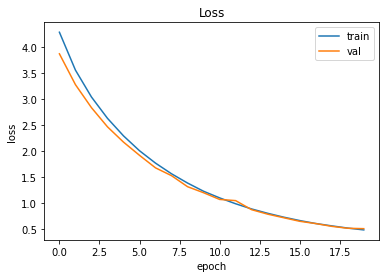

In [18]:
from matplotlib import pyplot
pyplot.plot(new_model_2_obj.history['loss'])
pyplot.plot(new_model_2_obj.history['val_loss'])
pyplot.title("Loss")
pyplot.ylabel("loss")
pyplot.xlabel("epoch")
pyplot.legend(['train', 'val'], loc='upper right')
pyplot.show()

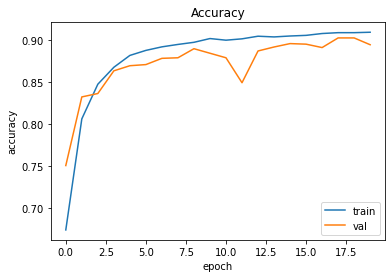

In [19]:
pyplot.plot(new_model_2_obj.history['accuracy'])
pyplot.plot(new_model_2_obj.history['val_accuracy'])
pyplot.title("Accuracy")
pyplot.ylabel("accuracy")
pyplot.xlabel("epoch")
pyplot.legend(['train', 'val'], loc='lower right')
pyplot.show()

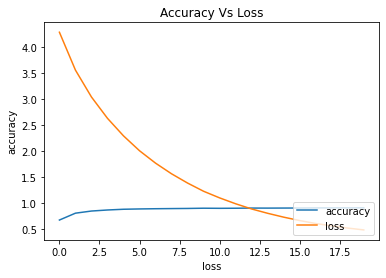

In [20]:
pyplot.plot(new_model_2_obj.history['accuracy'])
pyplot.plot(new_model_2_obj.history['loss'])
pyplot.title("Accuracy Vs Loss")
pyplot.ylabel("accuracy")
pyplot.xlabel("loss")
pyplot.legend(['accuracy', 'loss'], loc='lower right')
pyplot.show()

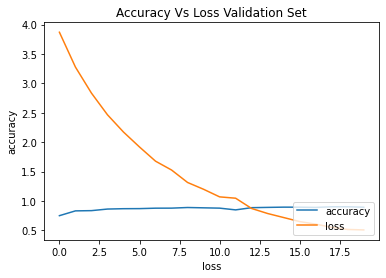

In [21]:
pyplot.plot(new_model_2_obj.history['val_accuracy'])
pyplot.plot(new_model_2_obj.history['val_loss'])
pyplot.title("Accuracy Vs Loss Validation Set")
pyplot.ylabel("accuracy")
pyplot.xlabel("loss")
pyplot.legend(['accuracy', 'loss'], loc='lower right')
pyplot.show()

In [22]:
df_test = pd.read_csv('COVID_dataset_test.csv',delimiter=',', error_bad_lines=False, warn_bad_lines=True)
df_test1 = df_test.drop(['id','Test_Reported_Date','Specimen_Date'],axis=1)
df_test1['Case_Reported_Date'] = pd.to_datetime(df_test1['Case_Reported_Date'])
df_test1['Accurate_Episode_Date'] = pd.to_datetime(df_test1['Accurate_Episode_Date'])
df_test1['Accurate_Episode_Date'] = df_test1['Accurate_Episode_Date'].astype(np.int64)
df_test1['Case_Reported_Date'] = df_test1['Case_Reported_Date'].astype(np.int64)
df_test1['Outbreak_Related'].replace(np.nan, 'No',inplace=True)
df_test1["Age_Group"].replace({"90s": 90, "80s": 80,"70s": 70, "60s": 60,"50s": 50, "40s": 40,"30s": 30, "20s": 20, "<20": 19 }, inplace=True)
dataset_test = pd.get_dummies(df_test1, columns = ['Client_Gender', 'Case_AcquisitionInfo','Reporting_PHU_City', 'Outbreak_Related'])
dataset_test

,Accurate_Episode_Date,Case_Reported_Date,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_FEMALE,Client_Gender_MALE,Client_Gender_UNSPECIFIED,Case_AcquisitionInfo_CC,Case_AcquisitionInfo_MISSING INFORMATION,...,Reporting_PHU_City_Sudbury,Reporting_PHU_City_Thorold,Reporting_PHU_City_Thunder Bay,Reporting_PHU_City_Timmins,Reporting_PHU_City_Toronto,Reporting_PHU_City_Waterloo,Reporting_PHU_City_Whitby,Reporting_PHU_City_Windsor,Outbreak_Related_No,Outbreak_Related_Yes
0,1593734400000000000,1593993600000000000,30,43.647471,-79.708893,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,1609804800000000000,1610496000000000000,80,44.301632,-78.321347,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1609545600000000000,1609977600000000000,60,43.656591,-79.379358,0,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,1607040000000000000,1607126400000000000,70,43.257631,-79.871341,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1610841600000000000,1611014400000000000,40,43.656591,-79.379358,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3699,1611273600000000000,1611273600000000000,30,43.656591,-79.379358,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3700,1585267200000000000,1585699200000000000,90,43.656591,-79.379358,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3701,1610582400000000000,1610841600000000000,40,43.462876,-80.520913,0,1,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3702,1611187200000000000,1611273600000000000,60,43.656591,-79.379358,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


In [23]:
ss = StandardScaler()
X = ss.fit_transform(dataset_test)
X

array([[-1.10792571, -1.12496395, -0.92271775, ..., -0.19966283,
         0.81943892, -0.81943892],
       [ 0.62329915,  0.66972215,  1.06559266, ..., -0.19966283,
         0.81943892, -0.81943892],
       [ 0.59537617,  0.61334457,  0.2702685 , ..., -0.19966283,
         0.81943892, -0.81943892],
       ...,
       [ 0.70706809,  0.7073072 , -0.52505566, ..., -0.19966283,
         0.81943892, -0.81943892],
       [ 0.77222172,  0.75428851,  0.2702685 , ..., -0.19966283,
         0.81943892, -0.81943892],
       [-2.09453773, -2.00821261,  1.06559266, ..., -0.19966283,
        -1.22034721,  1.22034721]])

In [24]:
test_lables_y = model.predict_classes(X)

In [25]:
test_lables_y

array([2, 0, 1, ..., 1, 1, 0], dtype=int64)

In [26]:
np.unique(test_lables_y)

array([0, 1, 2], dtype=int64)

[0]--->[1 0 0]
[1]--->[0 1 0]
[2]--->[0 0 1]

In [27]:
y1=np.where(test_lables_y==0,'Fatal',np.where(test_lables_y==1,'Not Resolved',np.where(test_lables_y==2,'Resolved',test_lables_y)))
y1

array(['Resolved', 'Fatal', 'Not Resolved', ..., 'Not Resolved',
       'Not Resolved', 'Fatal'], dtype='<U21')

In [28]:
y2 =pd.DataFrame(y1,columns=['Outcome1'])
covid_t1 =pd.DataFrame(df_test['id'],columns=['id'])
y_final = pd.concat([covid_t1, y2], axis=1)
y_final
y_final.to_csv(r'C:\\Users\\uttej\\OneDrive - University of Waterloo\\Documents\\657A\\A4\\COVID\\21.4\\covid_224_final.csv',index=False)